In [22]:
from datasets import Dataset, Features, Image, Value
import os
import json

In [23]:
# Paths to your images and JSON file
image_dir = 'data'
json_file = 'data/metadata.json'

In [24]:
# Load JSON metadata
with open(json_file, 'r') as f:
    metadata = json.load(f)

In [25]:
# Prepare data
data = {
    'image': [],
    'caption': []
}

# Load image file paths and captions
for item in metadata:
    image_path = os.path.join(image_dir, item['file_name'])
    
    if os.path.exists(image_path):
        data['image'].append(image_path)
        data['caption'].append(item['caption'])  # Make sure you're using 'caption' here based on your JSON structure
    else:
        print(f"Image {item['file_name']} not found.")

In [26]:
# Define the dataset features
features = Features({
    'image': Image(), 
    'caption': Value('string')
})

# Create the dataset
dataset = Dataset.from_dict(data, features=features)

In [27]:
# Load dataset from the hugging face
# from datasets import load_dataset
# dataset = load_dataset("VirtualMachine01/TrialDataset")

dataset

Dataset({
    features: ['image', 'caption'],
    num_rows: 12
})

In [28]:
dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2048x1152>,
 'caption': 'a male tennis player, dressed in an orange t-shirt and white headband, prepares to hit a green ball with a yellow racket he wears a silver ring on his'}

In [29]:
dataset[0]['caption']

'a male tennis player, dressed in an orange t-shirt and white headband, prepares to hit a green ball with a yellow racket he wears a silver ring on his'

In [30]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["caption"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding

In [31]:
from transformers import BlipProcessor
processor = BlipProcessor.from_pretrained("noamrot/FuseCap")
# processor = AutoProcessor.from_pretrained("microsoft/git-base")

/home/user/Meet_Patel/new1/newVenv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [32]:
train_dataset = ImageCaptioningDataset(dataset, processor)

In [33]:
item = train_dataset[0]
for k,v in item.items():
  print(k,v.shape)

pixel_values torch.Size([3, 384, 384])
input_ids torch.Size([512])
attention_mask torch.Size([512])


In [34]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

In [35]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 384, 384])
input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])


In [36]:
processor.decode(batch["input_ids"][0])

"[CLS] a man in a white shirt and blue shorts rides a brown horse on the beach under a blue sky with white clouds, while the horse's long black tail sways in [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

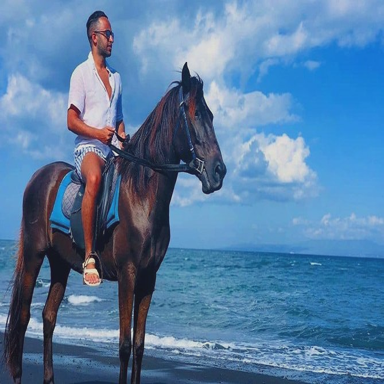

In [37]:
from PIL import Image
import numpy as np

MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [38]:
from transformers import BlipForConditionalGeneration
model = BlipForConditionalGeneration.from_pretrained("noamrot/FuseCap")

# print the total trainable parameters
# import torch
# trainable_params = [p for p in model.parameters() if p.requires_grad]
# num_trainable_params = sum(p.numel() for p in trainable_params)
# print(f"Number of trainable parameters: {num_trainable_params}")

In [39]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

tensor(9.7909, grad_fn=<NllLossBackward0>)

In [40]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = 'cpu'
model.to(device)

model.train()

for epoch in range(50):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 10.472794532775879
Loss: 9.801385879516602
Loss: 9.749292373657227
Loss: 9.694563865661621
Loss: 9.45258903503418
Loss: 9.215839385986328
Epoch: 1
Loss: 8.9747896194458
Loss: 8.745650291442871
Loss: 8.373266220092773
Loss: 8.416163444519043
Loss: 8.195297241210938
Loss: 7.990642070770264
Epoch: 2
Loss: 7.616561412811279
Loss: 7.508718967437744
Loss: 6.617076396942139
Loss: 6.384932994842529
Loss: 5.8437910079956055
Loss: 5.2521162033081055
Epoch: 3
Loss: 4.683365821838379
Loss: 4.132368087768555
Loss: 3.4506046772003174
Loss: 2.9717466831207275
Loss: 2.641890287399292
Loss: 2.149949789047241
Epoch: 4
Loss: 1.6320154666900635
Loss: 1.327807068824768
Loss: 1.0310313701629639
Loss: 0.8684155344963074
Loss: 0.6447693705558777
Loss: 0.6155655384063721
Epoch: 5
Loss: 0.43328526616096497
Loss: 0.3242487907409668
Loss: 0.3335150480270386
Loss: 0.2860289514064789
Loss: 0.19908760488033295
Loss: 0.19906200468540192
Epoch: 6
Loss: 0.24278025329113007
Loss: 0.16190394759178162
Loss: 0.100608

In [4]:
# Uploading the model on the huggingface models
from huggingface_hub import HfApi

# Save your model and tokenizer
model_directory = "fine_tuned_model"
model = BlipForConditionalGeneration.from_pretrained(model_directory)
processor = BlipProcessor.from_pretrained(model_directory)

model_name = "VirtualMachine01/caption-model"

# Initialize the API
api = HfApi()

# Upload the model files
api.upload_folder(
    folder_path=model_directory,
    repo_id=model_name,
    commit_message="Initial model upload"
)

pytorch_model.bin:   0%|          | 0.00/896M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/VirtualMachine01/caption-model/commit/e212a9e55a05b0bdf4eabf5c58987f4fd1132f59', commit_message='Initial model upload', commit_description='', oid='e212a9e55a05b0bdf4eabf5c58987f4fd1132f59', pr_url=None, pr_revision=None, pr_num=None)

In [5]:
# load image
example = dataset[2]
image = example["image"]
display(image)

NameError: name 'dataset' is not defined

In [6]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

NameError: name 'image' is not defined